In [2]:
import pandas as pd
import numpy as np
import requests
import shelve
from datetime import datetime
import os

#For the dropdown plot below
import seaborn as sns
from ipywidgets import interact, Dropdown
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [4]:
user="lholguin"
#user=asus

In [6]:
# Read the CSV file with NDC column as string to preserve leading zeros
year = 2023
csv_file = rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data\SDUD\SDUD{year}.csv"

print("Reading CSV file with proper dtype to preserve leading zeros...")

# Force NDC column to be read as string/object to preserve leading zeros
df = pd.read_csv(csv_file, dtype={'NDC': 'object'})

# Filter out rows with NA values in 'Units Reimbursed' or 'Number of Prescriptions' first
print(rf"Total rows in {year} before filtering: {len(df)}")
df_filtered = df.dropna(subset=['Units Reimbursed', 'Number of Prescriptions'])
print(f"Rows removed by NA filter: {len(df) - len(df_filtered)}")
print(f"Total rows after removing NA values in Units/Prescriptions: {len(df_filtered)}")


# Then filter out rows where State column equals 'XX'
before_state_filter = len(df_filtered)
df_filtered = df_filtered[df_filtered['State'] != 'XX']
print(f"Total rows after filtering out State='XX': {len(df_filtered)}")
#print(f"Rows removed by State filter: {before_state_filter - len(df_filtered)}")
print("Unique NDCs", df_filtered['NDC'].nunique())
#print(df_filtered.columns)
print(df_filtered.columns)


Reading CSV file with proper dtype to preserve leading zeros...
Total rows in 2023 before filtering: 5277298
Rows removed by NA filter: 2625771
Total rows after removing NA values in Units/Prescriptions: 2651527
Total rows after filtering out State='XX': 2413521
Unique NDCs 34439
Index(['Utilization Type', 'State', 'NDC', 'Labeler Code', 'Product Code',
       'Package Size', 'Year', 'Quarter', 'Suppression Used', 'Product Name',
       'Units Reimbursed', 'Number of Prescriptions',
       'Total Amount Reimbursed', 'Medicaid Amount Reimbursed',
       'Non Medicaid Amount Reimbursed'],
      dtype='object')


In [5]:
#Generating the txt file with the NDC values
# Save to text file

# Extract NDC column from filtered data - it's already in string format now
ndc_values = df_filtered['NDC']
output_file = rf"C:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\text_files\NDCf_{year}.txt"
print(f"Extracting {len(ndc_values)} NDC codes (All) with leading zeros preserved (excluding State='XX' and NA values)...")

#with open(output_file, 'w') as f:
    #for ndc in ndc_values:
        #f.write(str(ndc) + '\n')

#print(f"Successfully saved {len(ndc_values)} NDC values to NDCf_{year}.txt (State != 'XX', no NA values)")
print(f"Unique NDC values: {ndc_values.nunique()}")
print("First 10 NDC values (with leading zeros):")
print(ndc_values.head(10).tolist())

Extracting 2362630 NDC codes (All) with leading zeros preserved (excluding State='XX' and NA values)...
Unique NDC values: 33397
First 10 NDC values (with leading zeros):
['00002143380', '00002143480', '00002143611', '00002144511', '00002145780', '00002146080', '00002147180', '00002148480', '00002149580', '00002150680']


In [7]:
#Once you have run the code n2c.py then you'll have the ATC4 csv file to read in

year = 2023
# read ATC4 mapping, ensure NDC is read as string and zero-padded to 11 digits
file_path=rf'C:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\ATC4_classes\Classes_notgood\NDCf_{year}_ATC4_classes.csv'

df_atc4 = pd.read_csv(file_path, dtype={'NDC': 'object'})
df_atc4['NDC'] = df_atc4['NDC'].str.zfill(11)
#How many unique atc4 classes are there in the mapping file?
print(f"Unique ATC4 Classes in ATC4 mapping file: {df_atc4['ATC4 Class'].nunique()}")

print(df_atc4.columns)
print( rf"Unique NDCs of ATC csv {year}:", df_atc4['NDC'].nunique())
print("Total rows", len(df_atc4))
top_classes = df_atc4['ATC4 Class'].value_counts()
print(top_classes.head(10))
print(f"Filtered dataset has {len(df_filtered)} rows")

# Merge filtered SDUD data with ATC4 mapping on NDC

merged_df=pd.merge(df_filtered, df_atc4, on='NDC', how='left')
print(f"Merged dataframe has {len(merged_df)} rows")
print(f"Unique NDCs in merged dataframe: {merged_df['NDC'].nunique()}")
atc_counts = df_atc4['NDC'].value_counts()
print(atc_counts.value_counts().head(10))


Unique ATC4 Classes in ATC4 mapping file: 611
Index(['NDC', 'ATC4 Class'], dtype='object')
Unique NDCs of ATC csv 2023: 32499
Total rows 62105
ATC4 Class
H02AB    869
N06BA    764
S01BA    739
N06AX    737
C05AA    734
N03AX    706
S01AA    702
R01AD    701
B05XA    695
C09CA    640
Name: count, dtype: int64
Filtered dataset has 2413521 rows
Merged dataframe has 4454193 rows
Unique NDCs in merged dataframe: 34439
count
1     21716
2      4147
3      3289
4       909
5       731
7       516
11      262
8       262
6       230
9       189
Name: count, dtype: int64


In [7]:
# Looking at the unique ndc codes that does not have an atc4 class
missing_atc = merged_df[merged_df['ATC4 Class'].isna()]
print(rf"NDCs without ATC4 Class in {year} df: {missing_atc['NDC'].nunique()}")
#print(missing_atc['NDC'].head(10).tolist())
existing_atc = merged_df[merged_df['ATC4 Class'].notna()]
print(rf"NDCs with ATC4 Class in {year} df: {existing_atc['NDC'].nunique()}")

#Let's print those NDC codes to a text file to see if they have atc5 classes
missing_ndc_file = rf"C:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\text_files\NDC_missing_{year}.txt"
with open(missing_ndc_file, 'w') as f:
    for ndc in missing_atc['NDC'].unique():
        f.write(str(ndc) + '\n')
print(f"Saved missing NDCs to {missing_ndc_file}")

#Looking at the unique atc4 classes in the merged dataframe
print(rf"Unique ATC4 Classes in {year} merged dataframe: {merged_df['ATC4 Class'].nunique()}")


NDCs without ATC4 Class in 2024 df: 1193
NDCs with ATC4 Class in 2024 df: 32204
Saved missing NDCs to C:\Users\lholguin\OneDrive - purdue.edu\VS code\Data\ATC\text_files\NDC_missing_2024.txt
Unique ATC4 Classes in 2024 merged dataframe: 612


In [8]:
#Note that using the mapping atc5 for missing ndc is a little bit more detailed. Let's analyze it
miss_path=rf'C:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\NDC_missing_ATC5\NDC_missing_{year}_ATC5_classes.csv'
# C:\Users\lholguin\OneDrive - purdue.edu\VS code\Data\ATC\NDC_missing_2024_ATC5_classes.csv
df_miss=pd.read_csv(miss_path)
print(df_miss.head())
Rxcui_no = df_miss[df_miss['ATC5 Class'] == 'No RxCUI Found'].shape[0]
ATClass_no = df_miss[df_miss['ATC5 Class'] == 'No ATC Mapping Found'].shape[0]
print(f"Unique RxCUI in missing NDC mapping for {year}: {Rxcui_no}")
print(f"Unique ATC5 Class in missing NDC mapping for {year}: {ATClass_no}")

           NDC            ATC5 Class
0  50419032513        No RxCUI Found
1     26394825  No ATC Mapping Found
2  65219028102        No RxCUI Found
3    990799009        No RxCUI Found
4  51645073099        No RxCUI Found
Unique RxCUI in missing NDC mapping for 2024: 908
Unique ATC5 Class in missing NDC mapping for 2024: 285


In [9]:
#Function to get ATC class name from code
def get_atc_name(atc_code, cache):
    """Get ATC class name from code, using cache."""
    cache_key = f"atc_name:{atc_code}"
    if cache_key in cache:
        return cache[cache_key]
    
    try:
        url = f"https://rxnav.nlm.nih.gov/REST/rxclass/class/byId.json?classId={atc_code}"
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        
        # Get class name
        if 'rxclassMinConceptList' in data and 'rxclassMinConcept' in data['rxclassMinConceptList']:
            concepts = data['rxclassMinConceptList']['rxclassMinConcept']
            if concepts:
                name = concepts[0].get('className', '')
                cache[cache_key] = name
                return name
        
        cache[cache_key] = ''
        return ''
        
    except Exception as e:
        print(f"Error retrieving name for {atc_code}: {e}")
        cache[cache_key] = ''
        return ''

def add_all_atc_names(input_file, output_file=None, cache_path=None):
    """Add ATC class names for all levels (ATC2, ATC3, ATC4)."""
    
    # Set up cache path
    if cache_path is None:
        cache_dir = os.path.join(os.path.dirname(input_file), 'cache_files')
        os.makedirs(cache_dir, exist_ok=True)
        cache_path = os.path.join(cache_dir, 'atc_names_cache')
    
    print(f"Using cache: {cache_path}")
    
    # Read CSV
    print(f"Reading {input_file}...")
    df = pd.read_csv(input_file, dtype={'NDC': 'object'})
    
    print(f"Total rows: {len(df)}")
    print(f"Original columns: {df.columns.tolist()}")
    
    # Create ATC3 and ATC2 columns from ATC4
    print("\nCreating ATC3 and ATC2 columns from ATC4...")
    df['ATC3 Class'] = df['ATC4 Class'].str[:4]
    df['ATC2 Class'] = df['ATC4 Class'].str[:3]
    
    print(df[['ATC4 Class', 'ATC3 Class', 'ATC2 Class']].head(10))
    
    # Add name columns
    df['ATC4_Name'] = ''
    df['ATC3_Name'] = ''
    df['ATC2_Name'] = ''
    
    # Get unique codes for each level
    unique_atc4 = df['ATC4 Class'].dropna().unique()
    unique_atc3 = df['ATC3 Class'].dropna().unique()
    unique_atc2 = df['ATC2 Class'].dropna().unique()
    
    # Filter out invalid codes
    unique_atc4 = [c for c in unique_atc4 if c not in ['No ATC Mapping Found', 'No RxCUI Found', '']]
    unique_atc3 = [c for c in unique_atc3 if c not in ['No ATC Mapping Found', 'No RxCUI Found', '', 'No ', 'No']]
    unique_atc2 = [c for c in unique_atc2 if c not in ['No ATC Mapping Found', 'No RxCUI Found', '', 'No ', 'No']]
    
    print(f"\nUnique codes to fetch:")
    print(f"  ATC4: {len(unique_atc4)}")
    print(f"  ATC3: {len(unique_atc3)}")
    print(f"  ATC2: {len(unique_atc2)}")
    
    # Print unique counts
    print(f"\nUnique ATC4 Classes: {len(unique_atc4)}")
    print(f"Unique ATC3 Classes: {len(unique_atc3)}")
    print(f"Unique ATC2 Classes: {len(unique_atc2)}")
    
    total_codes = len(unique_atc4) + len(unique_atc3) + len(unique_atc2)
    
    # Build mappings
    atc4_names = {}
    atc3_names = {}
    atc2_names = {}
    
    with shelve.open(cache_path) as cache:
        start_time = datetime.now()
        processed = 0
        
        # Process ATC4
        print("\nFetching ATC4 names...")
        for code in unique_atc4:
            processed += 1
            if processed % 10 == 0:
                elapsed = (datetime.now() - start_time).total_seconds()
                rate = processed / elapsed if elapsed > 0 else 0
                remaining = (total_codes - processed) / rate if rate > 0 else 0
                print(f"Progress: {processed}/{total_codes} ({processed/total_codes*100:.1f}%) - "
                      f"Rate: {rate:.1f} codes/sec - ETA: {remaining/60:.1f} min")
                cache.sync()
            
            atc4_names[code] = get_atc_name(code, cache)
        
        # Process ATC3
        print("\nFetching ATC3 names...")
        for code in unique_atc3:
            processed += 1
            if processed % 10 == 0:
                elapsed = (datetime.now() - start_time).total_seconds()
                rate = processed / elapsed if elapsed > 0 else 0
                remaining = (total_codes - processed) / rate if rate > 0 else 0
                print(f"Progress: {processed}/{total_codes} ({processed/total_codes*100:.1f}%) - "
                      f"Rate: {rate:.1f} codes/sec - ETA: {remaining/60:.1f} min")
                cache.sync()
            
            atc3_names[code] = get_atc_name(code, cache)
        
        # Process ATC2
        print("\nFetching ATC2 names...")
        for code in unique_atc2:
            processed += 1
            if processed % 10 == 0:
                elapsed = (datetime.now() - start_time).total_seconds()
                rate = processed / elapsed if elapsed > 0 else 0
                remaining = (total_codes - processed) / rate if rate > 0 else 0
                print(f"Progress: {processed}/{total_codes} ({processed/total_codes*100:.1f}%) - "
                      f"Rate: {rate:.1f} codes/sec - ETA: {remaining/60:.1f} min")
                cache.sync()
            
            atc2_names[code] = get_atc_name(code, cache)
        
        print(f"\nTotal processing time: {(datetime.now() - start_time).total_seconds()/60:.1f} minutes")
    
    # Apply mappings to dataframe
    print("\nApplying names to dataframe...")
    df['ATC4_Name'] = df['ATC4 Class'].map(atc4_names).fillna('')
    df['ATC3_Name'] = df['ATC3 Class'].map(atc3_names).fillna('')
    df['ATC2_Name'] = df['ATC2 Class'].map(atc2_names).fillna('')
    
    # Reorder columns to group code and name together
    column_order = ['NDC', 
                    'ATC4 Class', 'ATC4_Name',
                    'ATC3 Class', 'ATC3_Name',
                    'ATC2 Class', 'ATC2_Name']
    df = df[column_order]
    
    # Save output
    if output_file is None:
        output_file = input_file.replace('.csv', '_with_names.csv')
    
    print(f"\nSaving to {output_file}...")
    df.to_csv(output_file, index=False)
    
    print(f"\nComplete! Output saved to: {output_file}")
    print(f"Total rows: {len(df)}")
    print("\nSample output:")
    print(df[['ATC4 Class', 'ATC4_Name', 'ATC3 Class', 'ATC3_Name', 'ATC2 Class', 'ATC2_Name']].head(10))
    
    return df

if __name__ == "__main__":
    # Configure paths
    year = 2024
    cache_path = rf"C:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\cache_files\atc_names_cache"
    input_file = rf"C:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\ATC4_classes\NDCf_{year}_ATC4_classes.csv"
    #"C:\Users\lholguin\OneDrive - purdue.edu\VS code\Data\ATC\ATC4_classes"
    output_file = rf"C:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\ATC4_names\ATC4_names{year}.csv"
    
    df = add_all_atc_names(input_file, output_file, cache_path)

Using cache: C:\Users\lholguin\OneDrive - purdue.edu\VS code\Data\ATC\cache_files\atc_names_cache
Reading C:\Users\lholguin\OneDrive - purdue.edu\VS code\Data\ATC\ATC4_classes\NDCf_2024_ATC4_classes.csv...
Total rows: 61470
Original columns: ['NDC', 'ATC4 Class']

Creating ATC3 and ATC2 columns from ATC4...
  ATC4 Class ATC3 Class ATC2 Class
0      N01BA       N01B        N01
1      A01AC       A01A        A01
2      A16AX       A16A        A16
3      R06AX       R06A        R06
4      S02BA       S02B        S02
5      B03BA       B03B        B03
6      D11AX       D11A        D11
7      C07AB       C07A        C07
8      C01BB       C01B        C01
9      B01AB       B01A        B01

Unique codes to fetch:
  ATC4: 612
  ATC3: 212
  ATC2: 89

Unique ATC4 Classes: 612
Unique ATC3 Classes: 212
Unique ATC2 Classes: 89

Fetching ATC4 names...
Progress: 10/913 (1.1%) - Rate: 10373.4 codes/sec - ETA: 0.0 min
Progress: 20/913 (2.2%) - Rate: 17271.2 codes/sec - ETA: 0.0 min
Progress: 30/913 (

In [10]:
#Analyzing the final dataframe with names
df_names=pd.read_csv(output_file, dtype={'NDC': 'object'})
ndc_final = df_names[df_names['NDC'].notna()]
print(rf"NDCs with ATC4 Class in {year} df: {ndc_final['NDC'].nunique()}") # CHECK the totals with the past prints
final_merged=pd.merge(df_filtered, df_names, on='NDC', how='left')
#Scaling down units reimbursed and number of prescriptions 
final_merged['Units Reimbursed'] = final_merged['Units Reimbursed'] / 1e6
final_merged['Number of Prescriptions'] = final_merged['Number of Prescriptions'] / 1e3

#Aggregating by State, ATC3 class and name
agg_df = final_merged.groupby(['State', 'ATC2 Class', 'ATC2_Name']).agg({
    'Units Reimbursed': 'sum',
    'Number of Prescriptions': 'sum'
}).reset_index()

print("Unique NDCs", final_merged['NDC'].nunique())
miss_values = final_merged[final_merged['ATC2 Class'].isna()]
print(rf"NDCs without ATC2 Class in final merged {year} df: {miss_values['NDC'].nunique()}")
#print(final_merged.columns)
#print(final_merged.head())

#Top 10 ATC2 classes nationally
top_atc2 = agg_df.groupby(['ATC2 Class', 'ATC2_Name']).agg({
    'Units Reimbursed': 'sum',
    'Number of Prescriptions': 'sum'
}).reset_index()
top_atc2 = top_atc2.sort_values(by='Units Reimbursed', ascending=False).head(10)
print(f"\nTop 10 ATC2 Classes Nationally:\n{top_atc2}")


NDCs with ATC4 Class in 2024 df: 32204
Unique NDCs 33397
NDCs without ATC2 Class in final merged 2024 df: 1193

Top 10 ATC2 Classes Nationally:
   ATC2 Class                                  ATC2_Name  Units Reimbursed  \
17        B05  BLOOD SUBSTITUTES AND PERFUSION SOLUTIONS      14798.529115   
11        A12                        MINERAL SUPPLEMENTS      10614.204078   
5         A06                     DRUGS FOR CONSTIPATION       5293.449080   
65        N02                                 ANALGESICS       4271.749955   
76        R03      DRUGS FOR OBSTRUCTIVE AIRWAY DISEASES       4253.819992   
80        S01                          OPHTHALMOLOGICALS       4234.748359   
48        J01            ANTIBACTERIALS FOR SYSTEMIC USE       4161.327965   
69        N06                           PSYCHOANALEPTICS       3563.983312   
68        N05                              PSYCHOLEPTICS       2378.420265   
66        N03                             ANTIEPILEPTICS       2334.959932  

In [11]:

# Create ATC3 aggregation
agg_atc2 = final_merged.groupby(['State', 'ATC2 Class', 'ATC2_Name', 'Year']).agg({
    'Units Reimbursed': 'sum',
    'Number of Prescriptions': 'sum'
}).reset_index()

print(f"ATC3 aggregated data shape: {agg_atc2.shape}")
print(f"Unique states: {agg_atc2['State'].nunique()}")
print(f"Unique ATC3 classes: {agg_atc2['ATC2 Class'].nunique()}")
print(f"Years available: {sorted(agg_atc2['Year'].unique())}")

# Interactive plotting function
def plot_atc2_analysis(year=2024, state='ALL', top_n=15, metric='Units Reimbursed'):

    # Filter data by year first
    year_data = agg_atc2[agg_atc2['Year'] == year].copy()
    
    # Filter data by state
    if state == 'ALL':
        plot_data = year_data.groupby(['ATC2 Class', 'ATC2_Name']).agg({
            'Units Reimbursed': 'sum',
            'Number of Prescriptions': 'sum'
        }).reset_index()
        title_suffix = f"Nationally ({year})"
    else:
        plot_data = year_data[year_data['State'] == state].copy()
        title_suffix = f"in {state} ({year})"
    
    # Sort by selected metric and get top N
    plot_data = plot_data.sort_values(metric, ascending=False).head(top_n)
    
    # Create subplot figure
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=(f'Top {top_n} ATC2 Classes by Units Reimbursed {title_suffix}',
                       f'Top {top_n} ATC2 Classes by Number of Prescriptions {title_suffix}'),
        vertical_spacing=0.1
    )
    
    # Units Reimbursed plot
    fig.add_trace(
        go.Bar(
            x=plot_data['Units Reimbursed'],
            y=plot_data['ATC2_Name'],
            orientation='h',
            name='Units Reimbursed',
            text=plot_data['Units Reimbursed'].round(1),
            textposition='auto',
            marker_color='lightblue'
        ),
        row=1, col=1
    )
    
    # Re-sort for prescriptions
    plot_data_presc = plot_data.sort_values('Number of Prescriptions', ascending=False).head(top_n)
    
    # Number of Prescriptions plot
    fig.add_trace(
        go.Bar(
            x=plot_data_presc['Number of Prescriptions'],
            y=plot_data_presc['ATC2_Name'],
            orientation='h',
            name='Number of Prescriptions',
            text=plot_data_presc['Number of Prescriptions'].round(1),
            textposition='auto',
            marker_color='lightcoral'
        ),
        row=2, col=1
    )
    
    # Update layout
    fig.update_layout(
        height=800,
        showlegend=False,
        title_text=f"ATC2 Drug Classes Analysis {title_suffix}",
        title_x=0.5
    )
    
    # Update x-axes
    fig.update_xaxes(title_text="Units Reimbursed (Millions)", row=1, col=1)
    fig.update_xaxes(title_text="Number of Prescriptions (Thousands)", row=2, col=1)
    
    # Update y-axes to show full names
    fig.update_yaxes(autorange="reversed", row=1, col=1)
    fig.update_yaxes(autorange="reversed", row=2, col=1)
    
    fig.show()
    
    # Print summary statistics
    print(f"\nSummary for {title_suffix}:")
    print(f"Total ATC2 classes: {len(plot_data)}")
    print(f"Total Units Reimbursed: {plot_data['Units Reimbursed'].sum():.1f} million")
    print(f"Total Prescriptions: {plot_data['Number of Prescriptions'].sum():.1f} thousand")

# Create widget for interactive plotting
states_list = ['ALL'] + sorted(agg_atc2['State'].unique().tolist())
years_list = sorted(agg_atc2['Year'].unique().tolist())

# Interactive widget
interact(plot_atc2_analysis,
         year=Dropdown(options=years_list, value=2024, description='Year:'),
         state=Dropdown(options=states_list, value='ALL', description='State:'),
         top_n=Dropdown(options=[10, 15, 20, 25], value=15, description='Top N:'),
         metric=Dropdown(options=['Units Reimbursed', 'Number of Prescriptions'], 
                        value='Units Reimbursed', description='Sort by:'))

ATC3 aggregated data shape: (4438, 6)
Unique states: 52
Unique ATC3 classes: 89
Years available: [np.int64(2024)]


interactive(children=(Dropdown(description='Year:', options=(2024,), value=2024), Dropdown(description='State:…

<function __main__.plot_atc2_analysis(year=2024, state='ALL', top_n=15, metric='Units Reimbursed')>

In [12]:

# Create ATC3 aggregation
agg_atc3 = final_merged.groupby(['State', 'ATC3 Class', 'ATC3_Name', 'Year']).agg({
    'Units Reimbursed': 'sum',
    'Number of Prescriptions': 'sum'
}).reset_index()

print(f"ATC3 aggregated data shape: {agg_atc3.shape}")
print(f"Unique states: {agg_atc3['State'].nunique()}")
print(f"Unique ATC3 classes: {agg_atc3['ATC3 Class'].nunique()}")
print(f"Years available: {sorted(agg_atc3['Year'].unique())}")

# Interactive plotting function
def plot_atc3_analysis(year=2024, state='ALL', top_n=15, metric='Units Reimbursed'):
    # Filter data by year first
    year_data = agg_atc3[agg_atc3['Year'] == year].copy()
    
    # Filter data by state
    if state == 'ALL':
        plot_data = year_data.groupby(['ATC3 Class', 'ATC3_Name']).agg({
            'Units Reimbursed': 'sum',
            'Number of Prescriptions': 'sum'
        }).reset_index()
        title_suffix = f"Nationally ({year})"
    else:
        plot_data = year_data[year_data['State'] == state].copy()
        title_suffix = f"in {state} ({year})"
    
    # Sort by selected metric and get top N
    plot_data = plot_data.sort_values(metric, ascending=False).head(top_n)
    
    # Create subplot figure
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=(f'Top {top_n} ATC3 Classes by Units Reimbursed {title_suffix}',
                       f'Top {top_n} ATC3 Classes by Number of Prescriptions {title_suffix}'),
        vertical_spacing=0.1
    )
    
    # Units Reimbursed plot
    fig.add_trace(
        go.Bar(
            x=plot_data['Units Reimbursed'],
            y=plot_data['ATC3_Name'],
            orientation='h',
            name='Units Reimbursed',
            text=plot_data['Units Reimbursed'].round(1),
            textposition='auto',
            marker_color='lightblue'
        ),
        row=1, col=1
    )
    
    # Re-sort for prescriptions
    plot_data_presc = plot_data.sort_values('Number of Prescriptions', ascending=False).head(top_n)
    
    # Number of Prescriptions plot
    fig.add_trace(
        go.Bar(
            x=plot_data_presc['Number of Prescriptions'],
            y=plot_data_presc['ATC3_Name'],
            orientation='h',
            name='Number of Prescriptions',
            text=plot_data_presc['Number of Prescriptions'].round(1),
            textposition='auto',
            marker_color='lightcoral'
        ),
        row=2, col=1
    )
    
    # Update layout
    fig.update_layout(
        height=800,
        showlegend=False,
        title_text=f"ATC3 Drug Classes Analysis {title_suffix}",
        title_x=0.5
    )
    
    # Update x-axes
    fig.update_xaxes(title_text="Units Reimbursed (Millions)", row=1, col=1)
    fig.update_xaxes(title_text="Number of Prescriptions (Thousands)", row=2, col=1)
    
    # Update y-axes to show full names
    fig.update_yaxes(autorange="reversed", row=1, col=1)
    fig.update_yaxes(autorange="reversed", row=2, col=1)
    
    fig.show()
    
    # Print summary statistics
    print(f"\nSummary for {title_suffix}:")
    print(f"Total ATC3 classes: {len(plot_data)}")
    print(f"Total Units Reimbursed: {plot_data['Units Reimbursed'].sum():.1f} million")
    print(f"Total Prescriptions: {plot_data['Number of Prescriptions'].sum():.1f} thousand")

# Create widget for interactive plotting
states_list = ['ALL'] + sorted(agg_atc3['State'].unique().tolist())
years_list = sorted(agg_atc3['Year'].unique().tolist())

# Interactive widget
interact(plot_atc3_analysis,
         year=Dropdown(options=years_list, value=2024, description='Year:'),
         state=Dropdown(options=states_list, value='ALL', description='State:'),
         top_n=Dropdown(options=[10, 15, 20, 25], value=15, description='Top N:'),
         metric=Dropdown(options=['Units Reimbursed', 'Number of Prescriptions'], 
                        value='Units Reimbursed', description='Sort by:'))

ATC3 aggregated data shape: (9895, 6)
Unique states: 52
Unique ATC3 classes: 212
Years available: [np.int64(2024)]


interactive(children=(Dropdown(description='Year:', options=(2024,), value=2024), Dropdown(description='State:…

<function __main__.plot_atc3_analysis(year=2024, state='ALL', top_n=15, metric='Units Reimbursed')>

   dms_orig  dms_dest               sctg2                   dms_mode  \
0        11         1  21-Pharmaceuticals                    1-Truck   
1        11         1  21-Pharmaceuticals    5-Multiple modes & mail   
2        11         2  21-Pharmaceuticals    5-Multiple modes & mail   
3        11         4  21-Pharmaceuticals  4-Air (include truck-air)   
4        11         4  21-Pharmaceuticals    5-Multiple modes & mail   

   thousand tons in 2017  thousand tons in 2018  thousand tons in 2019  \
0                79.8276                75.7832                77.5229   
1                 5.7772                 5.4845                 5.6104   
2                 0.0001                 0.0000                 0.0000   
3                 0.0238                 0.0226                 0.0231   
4                 0.1350                 0.1281                 0.1311   

   thousand tons in 2020  thousand tons in 2021  thousand tons in 2022  ...  \
0                79.5264                83.

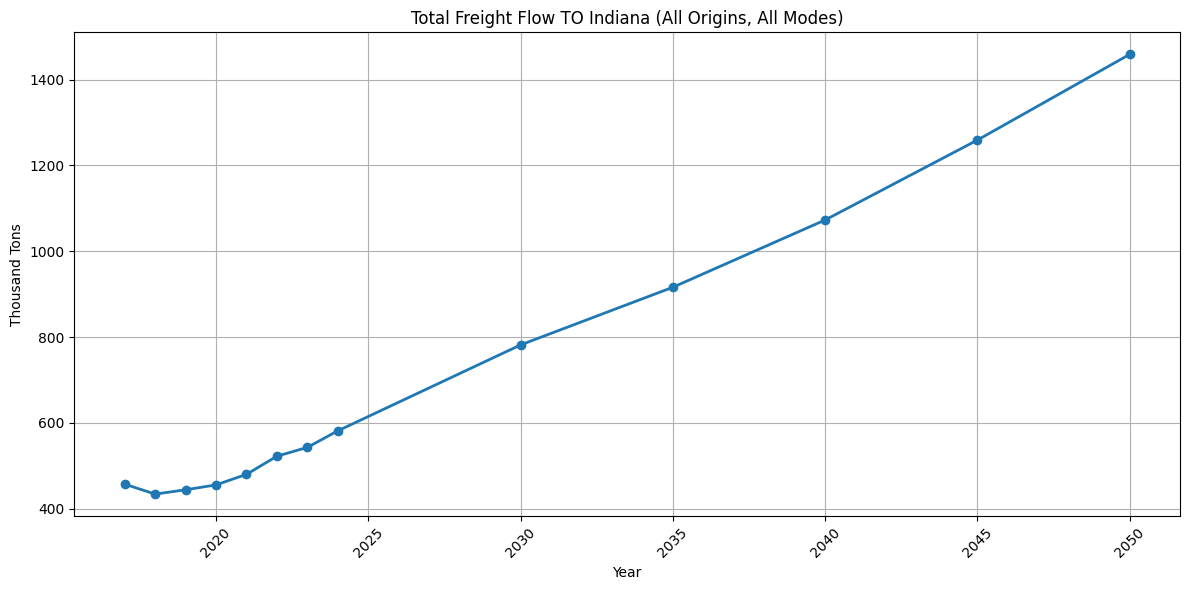


Summary for Indiana freight flows:
Average annual freight: 724 thousand tons
Peak year: 2050 with 1,459 thousand tons


In [13]:
#SEEING INDIANA FAF DATA
import re
# Load FAF data and create state filtering system

# Load the CSV file as a pandas DataFrame
#r"c:\Users\lholguin\OneDrive - purdue.edu\VS code\Data"
csv_path = rf"c:\Users\{user}\OneDrive - purdue.edu\VS code\Data\FAF\Dataset1.csv"
df = pd.read_csv(csv_path)
#df.head()
#df.columns.values

def extract_number(val):
    match = re.match(r'(\d+)-[A-Za-z]+', str(val))
    if match:
        return int(match.group(1))
    return val

# Replace 'col' with the actual column name you want to process
df['dms_orig'] = df['dms_orig'].apply(extract_number)
df['dms_dest'] = df['dms_dest'].apply(extract_number)
print(df.head())

# Filter for flows TO Indiana from ALL origins and ALL transportation modes
target_dest = 18  # Indiana destination code
indiana_flows = df[df['dms_dest'] == target_dest].copy()

print(f"Records flowing to Indiana: {len(indiana_flows)}")
print(f"Unique origins shipping to Indiana: {indiana_flows['dms_orig'].nunique()}")

# Get all year columns (2017-2050, excluding forecasts)
year_columns = [col for col in df.columns if col.startswith('thousand') and '_' not in col.lower()]
print(f"Available years: {year_columns[:10]}...")  # Show first 10 years

# Sum ALL freight (all origins, all modes) to Indiana by year
yearly_totals = indiana_flows[year_columns].sum()

# Show results for first 10 years
print(f"\nTotal freight to Indiana by year (first 10 years):")
for year in year_columns[:15]:
    print(f"{year}: {yearly_totals[year]:,.0f} thousand tons")
plt.figure(figsize=(12, 6))


# FIXED: Extract years correctly from column names
years = []
for col in year_columns:
    # Extract year from column name like 'thousand tons in 2017'
    year_match = re.search(r'(\d{4})', col)
    if year_match:
        years.append(int(year_match.group(1)))

values = [yearly_totals[year_col] for year_col in year_columns]

plt.plot(years, values, marker='o', linewidth=2)
plt.title('Total Freight Flow TO Indiana (All Origins, All Modes)')
plt.xlabel('Year')
plt.ylabel('Thousand Tons')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show summary statistics
print(f"\nSummary for Indiana freight flows:")
print(f"Average annual freight: {np.mean(values):,.0f} thousand tons")
print(f"Peak year: {years[np.argmax(values)]} with {max(values):,.0f} thousand tons")